In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
ESSENTIALITY_FILE = 'essentiality.csv'
ESSENTIALITY_DICT = {
    "Nonessential": 0,
    "Conditional": 1,
    "Essential": 2
}
essentialities = {}

num_lines_ess = sum(1 for line in open(ESSENTIALITY_FILE,'r'))
with open(ESSENTIALITY_FILE) as f:
    # titles
    f.readline()
    
    for i in tqdm(range(num_lines_ess)):
        line = f.readline().split(",")

        # ignore empty lines
        if len(line) < 2:
            continue

        ess = line[1]
        # sanity check
        if ess in ESSENTIALITY_DICT:
            essentialities[line[0]] = ESSENTIALITY_DICT[ess]

100%|██████████| 21557/21557 [00:00<00:00, 718116.49it/s]


In [3]:
print(sum([1 if v == ESSENTIALITY_DICT["Nonessential"] else 0 for k, v in essentialities.items()]))
print(sum([1 if v == ESSENTIALITY_DICT["Conditional"] else 0 for k, v in essentialities.items()]))
print(sum([1 if v == ESSENTIALITY_DICT["Essential"] else 0 for k, v in essentialities.items()]))

14388
6985
183


In [4]:
num_lines = sum(1 for line in open('introns.csv','r'))

with open('introns.csv') as f:
    
    num_start_gt = 0
    num_end_ag = 0
    total = 0
    
    for i in tqdm(range(num_lines)):
        code = f.readline().split(',')[4][:-1]
        if code[:2] == "GT":
            num_start_gt += 1
        if code[-2:] == "AG":
            num_end_ag += 1
        total += 1

print("percent start with GT: ", num_start_gt, 'out of ', total, ' = ', num_start_gt/total, '%')
print("percent end with AG: ", num_end_ag, 'out of ', total, ' = ', num_end_ag/total, '%')

100%|██████████| 248692/248692 [00:02<00:00, 89838.76it/s]

percent start with GT:  241805 out of  248692  =  0.9723071108037251 %
percent end with AG:  244830 out of  248692  =  0.9844707509690702 %


In [5]:
keys = {'A':0, 'C':1, 'G':2, 'T':3}
probs = np.zeros((4, 4))

with open('introns.csv') as f:
    for i in tqdm(range(num_lines)):
        code = f.readline().split(',')[4][:-1]
        code = code[2:6]
        
        for i, char in enumerate(code):
            if char == "N": 
                probs[i] += 0.25 # add equal weight to each base pair
            else:
                char_key = keys[char]
                probs[i][char_key] += 1

100%|██████████| 248692/248692 [00:03<00:00, 67577.86it/s]


In [6]:
print('Probabilities of each base pair appearing immediately after GT:')
print('  A          C          G          T')
print(probs / num_lines)

Probabilities of each base pair appearing immediately after GT:
  A          C          G          T
[[0.58617085 0.03152896 0.34753028 0.03443215]
 [0.69059419 0.0752668  0.12010137 0.1135712 ]
 [0.09108154 0.05997077 0.76940251 0.07901038]
 [0.18356944 0.14681715 0.18900186 0.48002449]]


In [10]:

def GC_densities(essential_filter=None, only_first_intron=False, not_first_intron=False):
    # as calculated above
        
    points_GC = []
    points_GT = []
    GC_count = 0
    GT_count = 0

    AG_count = 0

    start_with_gt = 0
    start_with_gt_count = 0
    end_with_ag = 0
    end_with_ag_count = 0

    num_base_pairs = 0
    num_introns_considered = 0
    genes_considered = set()

    with open('introns.csv') as f:
        for _ in tqdm(range(num_lines), position=0, leave=True):
            line = f.readline().split(',')
            gene = line[0]
            intron_num = int(line[3]) # <--- TODO check this is right
            code = line[4][:-1]

            # First intron filter, if applicable
            if only_first_intron and intron_num != 1:
                continue
                
            if not_first_intron and intron_num == 1:
                continue
                
            # Essentiality filter, if applicable
            if essential_filter != None:
                if gene in essentialities:
                    # essentiality is not what we want; skip it
                    if essentialities[gene] != ESSENTIALITY_DICT[essential_filter]:
                        continue
                else:
                    # we don't know essentiality; skip it
                    continue

            # If we passed all filters

            genes_considered.add(gene)
            num_introns_considered += 1
            num_base_pairs = len(code)
            
            
            GC_count = 0
            GT_count = 0
            #We begin at 6 to ignore the first 5' splice site
            for i in range(6,len(code)-1):

                if i < len(code) - 1:

                    # Look at sequences immediately following GC
                    if code[i:i+2] == "GC":
                        GC_count += 1


                    # Look at sequences immediately following GT
                    elif code[i:i+2] == "GT":
                        GT_count += 1

                #elif i > len(code) - BRANCH_LOC:
                #    if code[i:i+2] == "AG":
                #        AG_count += 1
                        
                    
            points_GC.append(GC_count/len(code))
            #points_GT.append([GT_counts/len(code)])
            
    if essential_filter != None:
        print(">>> ONLY CONSIDERING '" + essential_filter + "' GENES <<<")
    if only_first_intron:
        print(">>> ONLY CONSIDERING FIRST INTRONS <<<")

    return points_GC

In [11]:
results = []
for e in ["Essential", "Conditional", "Nonessential"]:
    all_intron = GC_densities(essential_filter=e)
    first = GC_densities(essential_filter=e, only_first_intron=True)
    not_first = GC_densities(essential_filter=e, not_first_intron=True)
    results.append([all_intron, first, not_first])


  4%|▍         | 10764/248692 [00:00<00:02, 107243.78it/s]

>>> ONLY CONSIDERING 'Essential' GENES <<<


  2%|▏         | 5498/248692 [00:00<00:04, 54809.13it/s]

>>> ONLY CONSIDERING 'Essential' GENES <<<
>>> ONLY CONSIDERING FIRST INTRONS <<<


  0%|          | 245/248692 [00:00<01:41, 2445.69it/s]

>>> ONLY CONSIDERING 'Essential' GENES <<<


  0%|          | 720/248692 [00:00<00:37, 6608.83it/s]

>>> ONLY CONSIDERING 'Conditional' GENES <<<


  0%|          | 383/248692 [00:00<01:06, 3748.97it/s]

>>> ONLY CONSIDERING 'Conditional' GENES <<<
>>> ONLY CONSIDERING FIRST INTRONS <<<


  0%|          | 204/248692 [00:00<04:55, 841.89it/s]

>>> ONLY CONSIDERING 'Conditional' GENES <<<


  0%|          | 271/248692 [00:00<01:38, 2517.93it/s]

>>> ONLY CONSIDERING 'Nonessential' GENES <<<


  0%|          | 272/248692 [00:00<03:55, 1053.77it/s]

>>> ONLY CONSIDERING 'Nonessential' GENES <<<
>>> ONLY CONSIDERING FIRST INTRONS <<<


100%|██████████| 248692/248692 [03:29<00:00, 1186.45it/s] 

>>> ONLY CONSIDERING 'Nonessential' GENES <<<


In [12]:
gc_result = results

In [ ]:
fig, axs = plt.subplots(3, 2, constrained_layout=True, figsize=(18,8))
for i , e in enumerate(["Essential", "Conditional", "Nonessential"]):
    for j in range(2):
        axs[i][j].hist(results[i][j], bins=50, rwidth=1, range=[0,0.2])
        axs[i][j].set_xlabel('GC Density')
        if j == 0:
            axs[i][j].set_title(e + ' GC (First Introns Only)')
        else:
            axs[i][j].set_title(e + ' GC (No First Introns)')

        axs[i][j].set_ylabel('Frequency')
        
        axs[i][j].text(0.75, 0.85, 'n:   ' + str(len(results[i][j])), transform=axs[i][j].transAxes)
        axs[i][j].text(0.75, 0.75, 'Mean:   ' + str(round(np.mean(results[i][j]), 5)), transform=axs[i][j].transAxes)
        axs[i][j].text(0.75, 0.65, 'Median: ' + str(round(np.median(results[i][j]), 5)), transform=axs[i][j].transAxes)
        axs[i][j].text(0.75, 0.55, 'Stddev: ' + str(round(np.std(results[i][j]), 5)), transform=axs[i][j].transAxes)
        
fig.suptitle('GC Essentiality by Essentiality and Intron Number', fontsize=16)
plt.show()

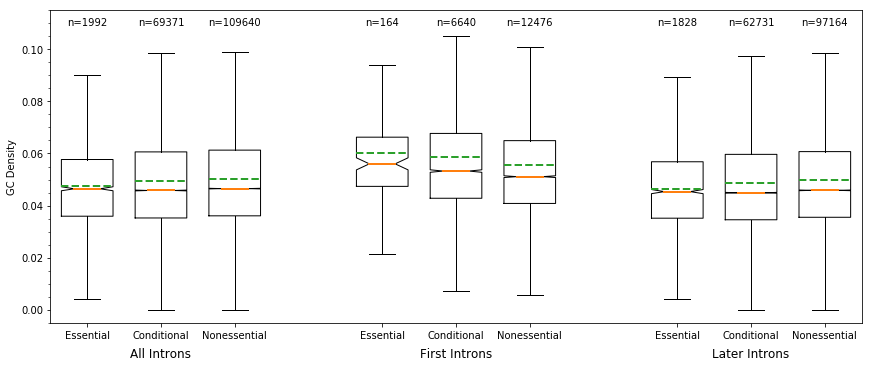

In [17]:
d = []
# for i, ess in enumerate(['Essential', 'Conditional', 'Nonessential']):
for i in range(3): #intron
    for k in range(3): #essentiality
        d.append(gc_result[k][i])

fig, ax = plt.subplots(constrained_layout=True, figsize=(12,5))

positions=[1, 2, 3, 5, 6, 7, 9, 10, 11]
labels = ['Essential', 'Conditional', 'Nonessential',
          'Essential', 'Conditional', 'Nonessential',
          'Essential', 'Conditional', 'Nonessential']

ax.boxplot(d, labels=labels, positions=positions, notch=True, showfliers=False, 
           showmeans=True, meanline=True, boxprops=dict(linewidth=1), medianprops=dict(linewidth=2),
           meanprops=dict(linewidth=2), widths=0.7) 
# Add n
for i in range(9):
    ax.text(positions[i], 0.95, 'n='+str(len(d[i])), horizontalalignment='center', transform=ax.get_xaxis_transform())

intron_desc = ["All Introns", "First Introns", "Later Introns"]
ax.text(positions[1], -0.11, 'All Introns', horizontalalignment='center', transform=ax.get_xaxis_transform(), size='large')
ax.text(positions[4], -0.11, 'First Introns', horizontalalignment='center', transform=ax.get_xaxis_transform(), size='large')
ax.text(positions[7], -0.11, 'Later Introns', horizontalalignment='center', transform=ax.get_xaxis_transform(), size='large')
    
# ax.set_xlabel('Gene Essentiality')
ax.set_ylabel('GC Density')
ax.set_ylim(top=0.115)

# ax.grid(True)
ax.minorticks_on()
ax.tick_params(axis='x', which='minor', bottom=False)

# fig.suptitle('Number of Introns per Gene', fontsize=16)
plt.savefig('figures/intron_gc_freq.png', dpi=300)
plt.show()

In [40]:

def GT_AG_sites(essential_filter=None, only_first_intron=False):
    # as calculated above
    probabilities = [
        [0.58617085, 0.03152896, 0.34753028, 0.03443215],
        [0.69059419, 0.0752668 , 0.12010137, 0.1135712 ],
        [0.09108154, 0.05997077, 0.76940251, 0.07901038],
        [0.18356944, 0.14681715, 0.18900186, 0.48002449]]
    keys = {'A':0, 'C':1, 'G':2, 'T':3}
    BRANCH_LOC = 40

    start_with_gt = 0
    start_with_gt_count = 0
    end_with_ag = 0
    end_with_ag_count = 0

    num_base_pairs = 0
    num_introns_considered = 0
    genes_considered = set()

    with open('introns.csv') as f:
        for _ in tqdm(range(num_lines), position=0, leave=True):
            line = f.readline().split(',')
            gene = line[0]
            intron_num = int(line[3]) # <--- TODO check this is right
            code = line[4][:-1]

            # First intron filter, if applicable
            if only_first_intron and intron_num != 1:
                continue
                
            if (not only_first_intron) and intron_num == 1:
                continue
                
            # Essentiality filter, if applicable
            if essential_filter != None:
                if gene in essentialities:
                    # essentiality is not what we want; skip it
                    if essentialities[gene] != ESSENTIALITY_DICT[essential_filter]:
                        continue
                else:
                    # we don't know essentiality; skip it
                    continue

            # If we passed all filters

            genes_considered.add(gene)
            num_introns_considered += 1
            num_base_pairs += len(code) - BRANCH_LOC - 6
            
            # Check start for GT
            if code[:2] == "GT":
                start_with_gt += 1
            start_with_gt_count += 1

            # Check end fot AG
            if code[-2:] == "AG":
                end_with_ag += 1
            end_with_ag_count += 1

                        
    if essential_filter != None:
        print(">>> ONLY CONSIDERING '" + essential_filter + "' GENES <<<")
    if only_first_intron:
        print(">>> ONLY CONSIDERING FIRST INTRONS <<<")

    print("Looked at", num_base_pairs, "base pairs from", num_introns_considered, "introns belonging to", len(genes_considered), "genes.")
    print()
    print("[MISC] % Start with GT: " + str(start_with_gt/start_with_gt_count) + "%  =  (" + str(start_with_gt) + "/" + str(start_with_gt_count) + ")")
    print("[MISC] % Ends with AG:  " + str(end_with_ag/end_with_ag_count) + "%  =  (" + str(end_with_ag) + "/" + str(end_with_ag_count) + ")")
                            
    return {
        "start_with_gt": start_with_gt,
        "start_with_gt_count": start_with_gt_count,
        "end_with_ag": end_with_ag,
        "end_with_ag_count": end_with_ag_count
    }

In [55]:
results_GT_first = []
results_GT_other = []
results_AG_first = []
results_AG_other = []
for e in ["Essential", "Conditional", "Nonessential"]:
    first =  GT_AG_sites(essential_filter=e, only_first_intron=True)
    not_first =  GT_AG_sites(essential_filter=e, only_first_intron=False)
    results_GT_first.append(first["start_with_gt"]/first["start_with_gt_count"])
    results_GT_other.append(not_first["start_with_gt"]/not_first["start_with_gt_count"])
    results_AG_first.append(first["end_with_ag"]/first["end_with_ag_count"])
    results_AG_other.append(not_first["end_with_ag"]/not_first["end_with_ag_count"])

 10%|▉         | 23948/248692 [00:00<00:01, 121191.59it/s]

>>> ONLY CONSIDERING 'Essential' GENES <<<
>>> ONLY CONSIDERING FIRST INTRONS <<<
Looked at 694923 base pairs from 164 introns belonging to 164 genes.

[MISC] % Start with GT: 0.9939024390243902%  =  (163/164)
[MISC] % Ends with AG:  1.0%  =  (164/164)


  9%|▉         | 23504/248692 [00:00<00:01, 119374.76it/s]

>>> ONLY CONSIDERING 'Essential' GENES <<<
Looked at 3825250 base pairs from 1828 introns belonging to 156 genes.

[MISC] % Start with GT: 0.9928884026258206%  =  (1815/1828)
[MISC] % Ends with AG:  0.9983588621444202%  =  (1825/1828)


  9%|▉         | 22647/248692 [00:00<00:01, 113934.63it/s]

>>> ONLY CONSIDERING 'Conditional' GENES <<<
>>> ONLY CONSIDERING FIRST INTRONS <<<
Looked at 79612840 base pairs from 6640 introns belonging to 6640 genes.

[MISC] % Start with GT: 0.9890060240963855%  =  (6567/6640)
[MISC] % Ends with AG:  0.9989457831325301%  =  (6633/6640)


  5%|▌         | 12464/248692 [00:00<00:01, 124621.40it/s]

>>> ONLY CONSIDERING 'Conditional' GENES <<<
Looked at 267057286 base pairs from 62731 introns belonging to 6134 genes.

[MISC] % Start with GT: 0.9908817012322456%  =  (62159/62731)
[MISC] % Ends with AG:  0.9979117182892031%  =  (62600/62731)


  5%|▍         | 11321/248692 [00:00<00:02, 113207.68it/s]

>>> ONLY CONSIDERING 'Nonessential' GENES <<<
>>> ONLY CONSIDERING FIRST INTRONS <<<
Looked at 175231813 base pairs from 12476 introns belonging to 12476 genes.

[MISC] % Start with GT: 0.9845302981724912%  =  (12283/12476)
[MISC] % Ends with AG:  0.9961526130169926%  =  (12428/12476)


100%|██████████| 248692/248692 [00:03<00:00, 81710.11it/s]

>>> ONLY CONSIDERING 'Nonessential' GENES <<<
Looked at 497641050 base pairs from 97164 introns belonging to 10874 genes.

[MISC] % Start with GT: 0.9898213330039932%  =  (96175/97164)
[MISC] % Ends with AG:  0.9980857107570705%  =  (96978/97164)


<BarContainer object of 6 artists>

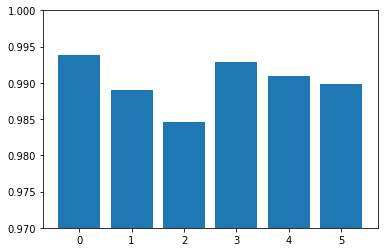

In [61]:
results_GT = results_GT_first + results_GT_other
results_AG = results_AG_first + results_AG_other


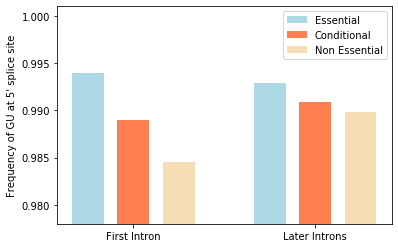

In [131]:
results_GT_Ess = [results_GT_first[0], results_GT_other[0]]
results_GT_Cond = [results_GT_first[1], results_GT_other[1]]
results_GT_Non = [results_GT_first[2], results_GT_other[2]]


#labels = ["Essential", "Conditional", "Nonessential"]
labels = ["First Intron",  "Later Introns"]
x = [0,3]
width = 0.7  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar([0,4], results_GT_Ess, width, label='Essential', color="lightblue")
rects2 = ax.bar([1,5], results_GT_Cond, width, label='Conditional', color="coral")
rects3 = ax.bar([2,6], results_GT_Non, width, label='Non Essential', color="wheat")
plt.ylim([0.978,1.001])
ax.set_ylabel('Frequency of GU at 5\' splice site')
#ax.set_title('Frequency of GU at 5\' splice site')

ax.set_xticks([1,5])
ax.set_xticklabels(labels)
ax.legend()

plt.show()

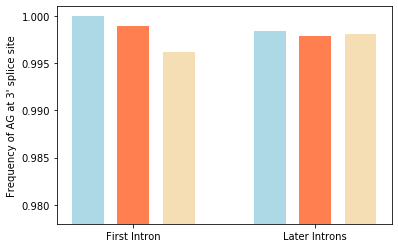

In [132]:
results_AG_Ess = [results_AG_first[0], results_AG_other[0]]
results_AG_Cond = [results_AG_first[1], results_AG_other[1]]
results_AG_Non = [results_AG_first[2], results_AG_other[2]]


#labels = ["Essential", "Conditional", "Nonessential"]
labels = ["First Intron",  "Later Introns"]
x = [0,3]
width = 0.7  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar([0,4], results_AG_Ess, width, label='Essential', color="lightblue")
rects2 = ax.bar([1,5], results_AG_Cond, width, label='Conditional', color="coral")
rects3 = ax.bar([2,6], results_AG_Non, width, label='Non Essential', color="wheat")
plt.ylim([0.978,1.001])

ax.set_ylabel('Frequency of AG at 3\' splice site')
#ax.set_title('Frequency of AG at 3\' splice site')

ax.set_xticks([1,5])
ax.set_xticklabels(labels)
#ax.legend()

plt.show()